# Task
Please download the following CSV with pseudo user access logs to our platform. Each entry (row) corresponds to a user’s access request to one of our many metrics on the platform. In particular, the file contains the following columns:

## Dataset 
- **id :** The customer ID, associated with a single customer
- **timestamp:** The time at which the access log was recorded
- **metric:** The path of the metric
- **params:** The query parameters associated with the metric request
- **a :** The requested asset
- **c:** The requested currency (USD or native)
- **i:** The requested interval/frequency
- **studio:** If True, the metric was accessed trough Studio (our web application). If false, the metric was accessed directly via our API
- **plan:** The product plan the user is on (can be A or B describing two different plans)


Given the above data we would like to obtain insights/answers to the following questions:


## Analysis
- **Studio vs API:** Is there a general user preference for accessing our data through Studio vs. API? Is there a difference for plan A users vs plan B users?


- **Top metrics:** What are the top 5 metrics for plan A users and the top 5 for plan B users ? Why is simply counting the number of access logs for a particular metric not an ideal approach to quantify this? What would you do instead?


- **API usage:** How many users use the API regularly? How would you define regularity here and apply this to your query/solution? Does API usage generally tend to show particular usage trends with respect to the parameters used, e.g. interval?


- **User churn:** Based on the above data, how many users come to our platform, perform any set of actions within a short time interval, and never come back?

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime as dt
import math
import pandasql as ps

In [2]:
pd.options.mode.chained_assignment = None 

In [3]:
csv_name = 'bichallenge.csv'
download_dir = '/Users/maxschlafli/Downloads'
csv_path = os.path.join(download_dir, csv_name)

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.describe()

,status_code
count,1.278929e+06
mean,2.300385e+02
std,7.550083e+01
min,0.000000e+00
25%,2.000000e+02
50%,2.000000e+02
75%,2.000000e+02
max,5.000000e+02


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278929 entries, 0 to 1278928
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   timestamp    1278929 non-null  object
 1   id           1278929 non-null  object
 2   metric       1278929 non-null  object
 3   params       1278929 non-null  object
 4   studio       1278929 non-null  bool  
 5   plan         1278929 non-null  object
 6   status_code  1278929 non-null  int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 59.8+ MB


In [7]:
df.isna().sum()

timestamp      0
id             0
metric         0
params         0
studio         0
plan           0
status_code    0
dtype: int64

In [8]:
#df.head(3)

In [9]:
def format_df(df=None):
    df['timestamp'] = df['timestamp'].apply(lambda x: pd.to_datetime(x, utc=True))
    df['asset'] = df['params'].apply(lambda x: json.loads(x)['a'])
    df['currency'] = df['params'].apply(lambda x: json.loads(x)['c'])
    df['frequency'] = df['params'].apply(lambda x: json.loads(x)['i'])
    df['access'] = df['studio'].apply(lambda x: 'Studio' if x == True else 'API')
    df['user_previous_timestamp' ] = df.groupby('id').timestamp.shift(1)
    df['user_min_timestamp' ] = df.groupby('id').timestamp.transform('min')
    df['hours_since_last_event'] = (df['timestamp'] - df['user_previous_timestamp']) / pd.Timedelta(hours=1)
    df['hours_since_last_event'] = df['hours_since_last_event'].apply(lambda x: math.floor(x) if math.isnan(x) == False else 0)
    df['days_since_last_event'] = (df['timestamp'] - df['user_previous_timestamp']) / pd.Timedelta(days=1)
    df['days_since_last_event'] = df['days_since_last_event'].apply(lambda x: math.floor(x) if math.isnan(x) == False else 0)
    df['days_since_first_event'] = (df['timestamp'] - df['user_min_timestamp']) / pd.Timedelta(days=1)
    df['days_since_first_event'] = df['days_since_first_event'].apply(lambda x: math.floor(x))
    return df

In [10]:
df = format_df(df=df)
#df.head(3)

In [11]:
users = df['id'].nunique()
print(f'{users} distinct users in the dataset')

4790 distinct users in the dataset


## Studio vs API:
- Is there a general user preference for accessing our data through
Studio vs. API?
- Is there a difference for plan A users vs plan B users?

In [12]:
def df_api_access(df=None):
    access = df.groupby('access')['id'].agg(['count','nunique'])
    access = access.rename(columns={'count':'user_logs','nunique':'users'})
    access['logs_per_user'] = round(access['user_logs'] / access['users'],1)
    access = access.drop(columns={'user_logs'})
    return access


def plot_api_access(df=None):
    df = df.reset_index()

    fig, ax1=plt.subplots(figsize=(5,8))
    sns.barplot(x = 'access', y='users', data=df, label='Users', color='grey')

    ax2 = ax1.twinx()
    sns.lineplot(x=ax1.get_xticks(), y='logs_per_user', data=df, color='blue', label='Logs p. User')

    ax1.set_ylim(0,3500)
    ax2.set_ylim(0,400)

    ax1.set_ylabel('Users', fontsize=15)
    ax2.set_ylabel('Logs p. User', fontsize=15)

    ax1.legend(loc = 2, fontsize = 10)
    ax2.legend(loc = 1, fontsize = 10)

    plt.show()

In [13]:
df_api_access = df_api_access(df=df)
df_api_access

,users,logs_per_user
access,,
API,3324,381.7
Studio,2035,5.0


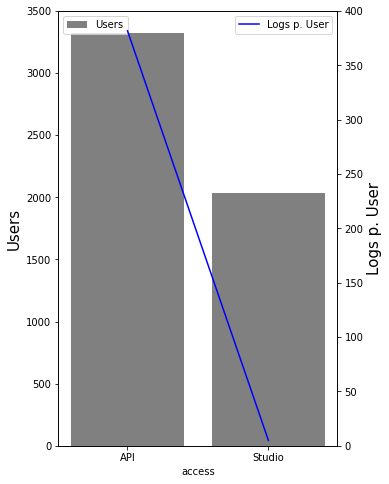

In [14]:
plot_api_access(df=df_api_access)

In [15]:
def df_api_access_split(df=None):
    user_plans = df.groupby('plan')['id'].agg(['count','nunique'])
    user_plans = user_plans.rename(columns={'count':'user_logs','nunique':'users'})
    user_plans['logs_per_user'] = round(user_plans['user_logs'] / user_plans['users'],2)
    return user_plans


def plot_api_access_split(df=df):
    df = df.reset_index()
    fig, ax1=plt.subplots(figsize=(5,8))
    sns.barplot(x = 'plan', y='users', data=df, label='Users', color='grey')

    ax2 = ax1.twinx()
    sns.lineplot(x=ax1.get_xticks(), y='logs_per_user', data=df, color='blue', label='Logs p. User')

    ax1.set_ylim(0,3500)
    ax2.set_ylim(0,400)

    ax1.set_ylabel('Users', fontsize=15)
    ax2.set_ylabel('Logs p. User', fontsize=15)

    ax1.legend(loc = 2, fontsize = 10)
    ax2.legend(loc = 1, fontsize = 10)

    plt.show()

In [16]:
df_api_access_split = df_api_access_split(df=df)
df_api_access_split

,user_logs,users,logs_per_user
plan,,,
A,210430,1924,109.37
B,1068499,3190,334.95


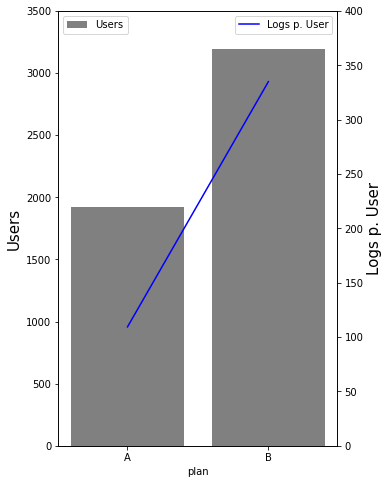

In [17]:
plot_api_access_split(df=df_api_access_split)

In [18]:
def df_api_access_plan_split(df=None):
    df = df.groupby(['access','plan'])['id'].agg(['count','nunique'])
    df = df.rename(columns={'count':'user_logs','nunique':'users'})
    df['logs_per_user'] = round(df['user_logs'] / df['users'],1)
    df = df.drop(columns={'user_logs'})
    return df


def plot_api_access_plan_split(df=None):
    df = df.reset_index()
    df['plan_access'] = df['access'] + '_' + df['plan']


    fig, ax1=plt.subplots(figsize=(5,8))
    sns.barplot(x='plan_access', y='users', data=df, label='Users', color='grey')

    ax2 = ax1.twinx()
    sns.lineplot(x=ax1.get_xticks(), y='logs_per_user', data=df, color='blue', label='Logs p. User')

    ax1.set_ylim(0,3500)
    ax2.set_ylim(0,800)

    ax1.set_ylabel('Users', fontsize=15)
    ax2.set_ylabel('Logs p. User', fontsize=15)

    ax1.legend(loc = 2, fontsize = 10)
    ax2.legend(loc = 1, fontsize = 10)

    plt.show()


In [19]:
df_api_access_plan_split = df_api_access_plan_split(df=df)
df_api_access_plan_split

users  logs_per_user
access plan                      
API    A       304          669.7
       B      3050          349.3
Studio A      1743            3.9
       B       297           10.9

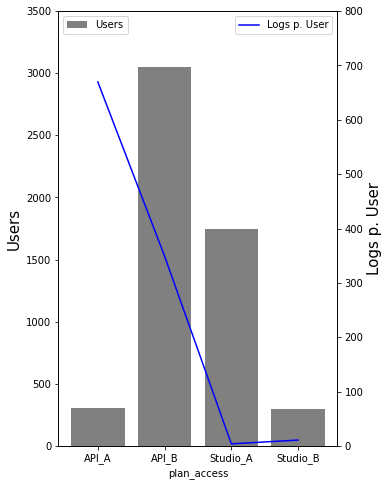

In [20]:
plot_api_access_plan_split(df=df_api_access_plan_split)

### Studio vs API Analysis

- Is there a general user preference for accessing our data through
Studio vs. API?
- Is there a difference for plan A users vs plan B users?


#### Analysis
- Approx. 40% of users use the studio and 60% use the api
- In line with expectations we see API users have significantly more events (380 vs 5)
- When we look at the plan split, we see the majority of users in plan B versus plan A (approx. 60% vs 40%)
- We also see that plan A users are more likely to use the studio and plan B users are more likely to use the API

##### Worth noting:
- There are also subset of users who use both the studio & api as well possibly having events in plan A and B, since the aggregated user numbers in the grouped data is larger than the distinct number of users in the dataset    

## Top metrics:
- What are the top 5 metrics for plan A users and the top 5 for plan B
users ?
- Why is simply counting the number of access logs for a particular metric
not an ideal approach to quantify this?
- What would you do instead?

In [21]:
def get_top_5_metrics(df=df):
    top_metrics = df.copy()
    top_metrics = df.groupby(['plan','metric'])['id'].agg(['count','nunique'])
    top_metrics.reset_index(inplace=True) 
    top_metrics = top_metrics.rename(columns={'count':'total_events','nunique':'users_with_event'})
    top_metrics['events_per_user'] = round(top_metrics['total_events'] / top_metrics['users_with_event'],2)
    top_metrics['rank'] = top_metrics.groupby('plan')['users_with_event'].rank(ascending=False)
    top_metrics = top_metrics[top_metrics['rank'] <= 5].sort_values(['plan','users_with_event'], ascending=[True, False])
    top_metrics.set_index('plan', inplace=True)
    top_metrics[['metric','users_with_event','events_per_user']]
    return top_metrics

In [22]:
get_top_5_metrics(df=df)

,metric,total_events,users_with_event,events_per_user,rank
plan,,,,,
A,indicators/3iq_ethq_premium_percent,6246,364,17.16,1.0
A,eth2/staking_total_volume_sum,6994,194,36.05,2.0
A,indicators/sol_1w_1m,1520,189,8.04,3.0
A,mining/revenue_from_fees,1677,175,9.58,4.0
A,indicators/sopr_more_155,2083,159,13.10,5.0
B,indicators/sol_1w_1m,12091,1039,11.64,1.0
B,indicators/3iq_ethq_premium_percent,28989,603,48.07,2.0
B,mempool/txs_value_sum,7594,581,13.07,3.0
B,distribution/non_zero_count,9401,378,24.87,4.0


### Top metrics Analysis
- What are the top 5 metrics for plan A users and the top 5 for plan B
users ?
- Why is simply counting the number of access logs for a particular metric
not an ideal approach to quantify this?
- What would you do instead?


#### Analysis
- Only counting the logs will distort which metrics are most popular, since it's possible that power users will have a significant disproportinate amount of events
- I've therefore counted the distinct number of users with a particular event as well as events per user

# API usage:
- How many users use the API regularly? 
- How would you define regularity here and apply this to your query/solution? 
- Does API usage generally tend to show particular usage trends with respect to the parameters used, e.g.
interval?

#### Methodology & Definition
- Look at the distribution of all platform logs relative to a users first event to identify any usage patterns

#### Defining usage regularity
- I've decided to measure activity by the number of distinct days on which user is using the acitivty
    - A user with 7 distinct days, in which each day had 100 logs, would have 7 active usage days
    - Preferred over using total event logs, since it's probably that power users have 100s/1000s of logs within a day


- Dataset is aggregated on a user level with their number of usage days
- Percentiles are then calculated (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.90, 0.95, 0.99, 1)
- Each user is assigned a label of their usage days percentile
- This label is then added to the initial log dataset, so we can group the data by the percentile, and see how activte those user groups are

In [23]:
def api_df(df=None):
    dfapi = df.copy()
    dfapi['user_previous_timestamp' ] = dfapi.groupby('id').timestamp.shift(1)
    dfapi['user_min_timestamp' ] = dfapi.groupby('id').timestamp.transform('min')
    dfapi['hours_since_last_event'] = (dfapi['timestamp'] - dfapi['user_previous_timestamp']) / pd.Timedelta(hours=1)
    dfapi['hours_since_last_event'] = dfapi['hours_since_last_event'].apply(lambda x: math.floor(x) if math.isnan(x) == False else 0)
    dfapi['days_since_last_event'] = (dfapi['timestamp'] - dfapi['user_previous_timestamp']) / pd.Timedelta(days=1)
    dfapi['days_since_last_event'] = dfapi['days_since_last_event'].apply(lambda x: math.floor(x) if math.isnan(x) == False else 0)
    dfapi['days_since_first_event'] = (dfapi['timestamp'] - dfapi['user_min_timestamp']) / pd.Timedelta(days=1)
    dfapi['days_since_first_event'] = dfapi['days_since_first_event'].apply(lambda x: math.floor(x))
    dfapi['weeks_since_first_event'] = dfapi['days_since_first_event'].apply(lambda x: math.floor(x/7))
    
    return dfapi

def plot_api_days_since_first_event_histgram(df=None):
    fix, ax=plt.subplots(figsize=(10,6))
    ax = sns.histplot(data=df['days_since_first_event'], bins=100, ax=ax)
    
    plt.show()

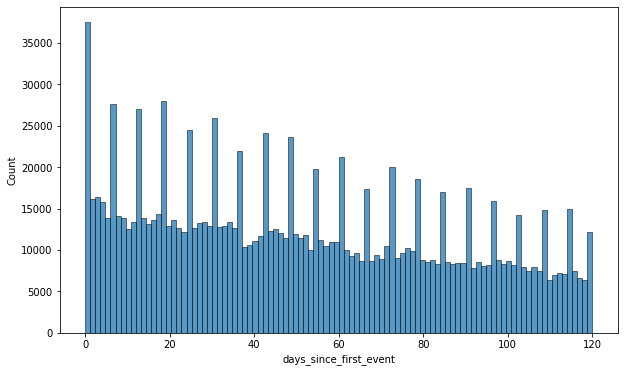

In [24]:
plot_api_days_since_first_event_histgram(df=df)

### Observations
- Looking at distribution of log data relative to a users first log timestamp
- Clear usage spikes on what seem to be 7-day intervals, suggesting the structured access/fetching of data from the platform

In [25]:
def get_api_usage_days_percentiles(df=None):
    
    df = df.groupby('id').apply(lambda x: pd.Series({
          'api_usage_days': x['timestamp'].dt.strftime('%Y%m%d').nunique()
    }))
    
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.90, 0.95, 0.99, 1]
    df = df['api_usage_days'].quantile(q=quantiles)
    
    return df
    

In [26]:
user_api_usage_days_percentiles = get_api_usage_days_percentiles(df=df)
user_api_usage_days_percentiles

0.10      1.0
0.20      1.0
0.30      3.0
0.40      5.0
0.50      7.0
0.60     10.0
0.70     12.0
0.80     20.0
0.90     37.0
0.95     56.0
0.99    117.0
1.00    121.0
Name: api_usage_days, dtype: float64

In [27]:
def usage_percentile(row):
    if row['api_usage_days'] <= 1:
        return ' 20th Percentile'
    elif row['api_usage_days'] <= 3:
        return ' 30th Percentile'
    elif row['api_usage_days'] <= 5:
        return ' 40th Percentile'
    elif row['api_usage_days'] <= 7:
        return ' 50th Percentile'
    elif row['api_usage_days'] <= 10:
        return ' 60th Percentile'
    elif row['api_usage_days'] <= 12:
        return ' 70th Percentile'
    elif row['api_usage_days'] <= 20:
        return ' 80th Percentile'
    elif row['api_usage_days'] <= 37:
        return ' 90th Percentile'
    elif row['api_usage_days'] <= 56:
        return ' 95th Percentile'
    elif row['api_usage_days'] <= 117:
        return ' 99th Percentile' 
    elif row['api_usage_days'] > 117:
        return '100th Percentile'
    else:
        return None
    


def assign_user_api_usage_percentile(df=None):
    df = df.groupby('id').apply(lambda x: pd.Series({
        'api_usage_days': (x['timestamp'].dt.strftime('%Y%m%d')+x['id']).nunique()
        }))
    df['api_avg_days_used_percentile'] = df.apply(lambda row: usage_percentile(row), axis=1)
    return df



def user_api_usage_agg(df=None):
    df = df.groupby('api_avg_days_used_percentile').apply(lambda x: pd.Series({
          'users': x['id'].nunique()
        , 'api_usage_days': (x['timestamp'].dt.strftime('%Y%m%d')+x['id']).nunique()
        , 'events': x['id'].count()
        , 'hours_between_events': round(x['hours_since_last_event'].mean(),2)
    }))

    df['avg_api_usage_days'] = round(df['api_usage_days'] / df['users'],1)
    df['events_per_user'] = round(df['events'] / df['users'],1)
    df['events_per_day'] = round(df['events'] / df['api_usage_days'],1)
    
    df = df[['users','events','avg_api_usage_days','events_per_user','events_per_day','hours_between_events']]
    
    return df

In [28]:
user_api_usage_percentile_df = assign_user_api_usage_percentile(df=df)
df = df.merge(user_api_usage_percentile_df, left_on='id', right_on='id')
user_api_usage_agg = user_api_usage_agg(df=df)

In [29]:
user_api_usage_agg

,users,events,avg_api_usage_days,events_per_user,events_per_day,hours_between_events
api_avg_days_used_percentile,,,,,,
20th Percentile,984.0,1109.0,1.0,1.1,1.1,0.10
30th Percentile,658.0,2152.0,2.4,3.3,1.4,259.24
40th Percentile,392.0,2629.0,4.5,6.7,1.5,239.10
50th Percentile,406.0,15021.0,6.5,37.0,5.7,53.81
60th Percentile,645.0,6429.0,9.0,10.0,1.1,229.15
70th Percentile,273.0,3480.0,11.4,12.7,1.1,185.18
80th Percentile,501.0,13786.0,16.1,27.5,1.7,90.64
90th Percentile,456.0,55150.0,27.8,120.9,4.3,21.90
95th Percentile,248.0,23002.0,46.6,92.8,2.0,29.23


In [30]:
def user_api_usage_agg_freq_split(df=None):
    
    df = df.groupby(['frequency','api_avg_days_used_percentile']).apply(lambda x: pd.Series({
          'users': x['id'].nunique()
        , 'api_usage_days': (x['timestamp'].dt.strftime('%Y%m%d')+x['id']).nunique()
        , 'events': x['id'].count()
        , 'hours_between_events': round(x['hours_since_last_event'].mean(),2)
    }))

    df['avg_api_usage_days'] = round(df['api_usage_days'] / df['users'],1)
    df['events_per_user'] = round(df['events'] / df['users'],1)
    df['events_per_day'] = round(df['events'] / df['api_usage_days'],1)
    df = df.reset_index()#.set_index('api_avg_days_used_percentile')
    df = df[['api_avg_days_used_percentile','frequency','users','events_per_user','events_per_day','hours_between_events']]
    
    return df

In [31]:
api_usage_freq_split = user_api_usage_agg_freq_split(df=df)
api_usage_freq_split = api_usage_freq_split[api_usage_freq_split['frequency'].isin(['10m','1h','24h'])]
api_usage_freq_split.pivot(index='api_avg_days_used_percentile', columns='frequency', values=['users','events_per_user','events_per_day','hours_between_events'])

users              events_per_user          \
frequency                      10m    1h    24h             10m      1h   
api_avg_days_used_percentile                                              
 20th Percentile               2.0  15.0  965.0             1.0     1.4   
 30th Percentile               3.0  18.0  653.0             6.0     9.6   
 40th Percentile               7.0  23.0  387.0            27.3    10.4   
 50th Percentile               8.0  16.0  394.0          1083.9   174.9   
 60th Percentile               5.0  14.0  620.0            13.0     8.7   
 70th Percentile               6.0  14.0  264.0            14.7     8.4   
 80th Percentile              12.0  37.0  493.0             8.9    24.2   
 90th Percentile              20.0  57.0  449.0           861.0   175.8   
 95th Percentile              21.0  49.0  245.0            85.2    42.6   
 99th Percentile              36.0  65.0  176.0          2771.1  1194.4   
100th Percentile              21.0  33.0   47.0         16027.3  8240.6   

                                     events_per_day              \
frequency                        24h            10m    1h   24h   
api_avg_days_used_percentile                                      
 20th Percentile                 1.1            1.0   1.4   1.1   
 30th Percentile                 2.9            4.5   6.4   1.3   
 40th Percentile                 5.4           13.6   3.8   1.2   
 50th Percentile                 8.5          279.7  39.4   1.3   
 60th Percentile                 9.8            2.4   1.1   1.1   
 70th Percentile                12.2            1.8   1.5   1.1   
 80th Percentile                25.9            1.2   3.5   1.7   
 90th Percentile                62.1           72.0  15.2   2.3   
 95th Percentile                76.8            4.9   2.5   1.8   
 99th Percentile               646.3           67.5  23.8   9.4   
100th Percentile              4444.6          164.3  78.5  44.2   

                             hours_between_events                  
frequency                                     10m      1h     24h  
api_avg_days_used_percentile                                       
 20th Percentile                             0.00    0.00    0.10  
 30th Percentile                             4.72   14.54  289.38  
 40th Percentile                             6.21   58.95  288.92  
 50th Percentile                             0.44    5.37  232.08  
 60th Percentile                            73.14  209.90  230.76  
 70th Percentile                            90.84  112.09  191.16  
 80th Percentile                           114.55   34.88   94.25  
 90th Percentile                             1.16    5.15   40.71  
 95th Percentile                             8.86   17.74   32.92  
 99th Percentile                             0.18    0.71    3.44  
100th Percentile                             0.02    0.07    0.19

### API Analysis
- How many users use the platform regularly and how do usage trends behave relative to frequency parameters
- From the 30th percentile updwards we start seeing regular usage, with a significant increase in activity as we move up the percentiles

- 70% percent of users show at least moderate platform usage, with the 30th percentile showing:
    - An average of 3.3 logs, across 2.4 days
- At least half the users (50th percentile) use the platform regularly, with:
    - An average of 37 logs, across 6.5 days
    
- We see a pretty moderate increase in activity towards the 90th percentile, and then extreme power users in the +99th percentiles, where we observe near daily usage, and multiple daily events, totalling 1000s over the entire usage period




#### Frequency paramater
- I've looked at some of the larger frequency groups which also reflect significant differences in the interval (10m, 1h, 24h)
- Unsurprinsigly we see that shorter intervals (10m / 1h) have higher usage than the longer intervals
- Power users are fetching data 70-150+ times per day

# User churn:
- Based on the above data, how many users come to our platform,
perform any set of actions within a short time interval, and never come back?


#### Methodology & Definition
- Activity/Event defined has any user log (studio / api access), relative to the timestamp of their first log

**Definitions: Retained**
- D0: Users with activity on day 0
- D1+: Users with an activity on or after day 1
- D7+: Users with an activity on or after day 7
- D30+: Users with an activity on or after day 30
- D60+: Users with an activity on or after day 60
- D90+: Users with an activity on or after day 90

**Definitions: Churned**
- Inverse of retained
- e.g. D1+: What percentage of users never have on event on or after day 1

In [32]:
def user_churn_df(df = None):
    churned = df.groupby('id').apply(lambda x: pd.Series({
          'D0': x[x['days_since_first_event']==0]['id'].nunique()
        , 'D1+': x[x['days_since_first_event']>=1]['id'].nunique()
        , 'D7+': x[x['days_since_first_event']>=7]['id'].nunique()
        , 'D30+': x[x['days_since_first_event']>=30]['id'].nunique()
        , 'D60+': x[x['days_since_first_event']>=60]['id'].nunique()
        , 'D90+': x[x['days_since_first_event']>=90]['id'].nunique()
    }))

    churned = churned.sum()
    churned = churned.reset_index().rename(columns={'index':'period', 0:'users_retained'})
    churned['users_churned'] = churned['users_retained'].iloc[0] - churned['users_retained']
    churned['users_churned [%]'] = round(churned['users_churned'] / churned['users_retained'].iloc[0], 4)*100
    churned['users_churned [%]'] = churned['users_churned [%]'].apply(lambda x: f'{round(x,1)}%')
    churned['users_retained [%]'] = round(churned['users_retained'] / churned['users_retained'].iloc[0], 4)*100
    churned['users_retained [%]'] = churned['users_retained [%]'].apply(lambda x: f'{round(x,1)}%')
    churned = churned.set_index('period')
    
    return churned


def plot_user_churn_and_retention(data=None):
    fig, [ax1, ax2] = plt.subplots(ncols=2, nrows=1, figsize=(15,6))
    sns.lineplot(data=data, x='period', y='users_retained', marker='o', ax=ax1)
    sns.lineplot(data=data, x='period', y='users_churned', marker='o', ax=ax2)
    plt.show()

In [33]:
churn_df = user_churn_df(df=df)
churn_df

,users_retained,users_churned,users_churned [%],users_retained [%]
period,,,,
D0,4790,0,0.0%,100.0%
D1+,3781,1009,21.1%,78.9%
D7+,3668,1122,23.4%,76.6%
D30+,3357,1433,29.9%,70.1%
D60+,2996,1794,37.5%,62.5%
D90+,2372,2418,50.5%,49.5%


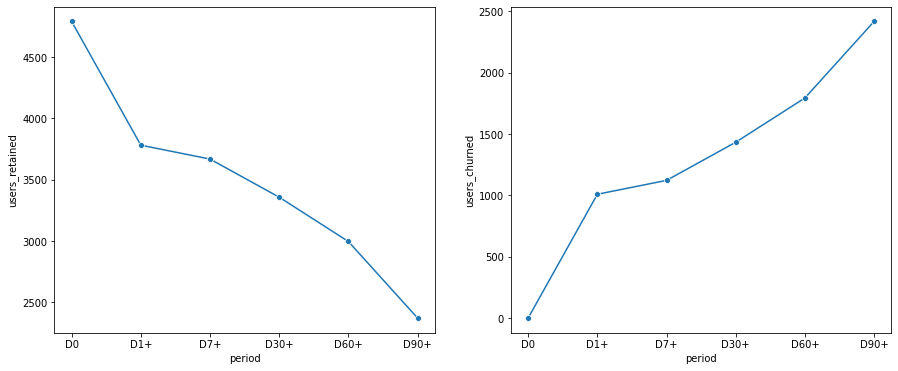

In [34]:
plot_user_churn_and_retention(data=churn_df)

### Churn/Retention Analysis
- Majority of users return to the platform after Day 0
    - About 80% of users return to the platform after D0 (21.1% churn)
    - 70% of users return to the patform on or after D30 (30% churn)
    - On or after D90, half of the users still return to the platform